# SI 370 Final Project
# Nicole Zeffer - nzeffer

# Intro:

### I wanted to use League of Legends' API to determine how dense the top player network would be, and do some regressional analysis to determine if certain in-game variables were correlated or not (and if they were--how much).

### First, I collected the initial data (it was a long process).
#### Step 1 - Scraped top North American player names from lolsummoners.com
#### Step 2 - Plugged top player names (step 1 output) into the Riot API to retrieve playerIDs for each player
#### Step 3 - Plugged playerIDs (step 2 output) into the Riot API to retrieve recent match history IDs for each playerID
#### Step 4 - Plugged match history IDs (step 3 output) into Riot API to retrieve detailed match info (in this case, playerIDs for players who participated in the match)

# Techniques and Analysis:

### I used networkx to generate and vizualize a node network of the top players with my collected data. I also performed centrality analysis on the network, and determined who the most important players were.
### Next, I try (and somewhat fail) to generate a time series for damage dealt for the top 5 players. I had a great deal of difficulty with this one, because for some reason, if I used a dataset past a certain size, I would get countless errors (so I was forced into only being able to use the most recent 40 matches). This caused a LOT of gaps in my time series as you can see in the visualization. Additionally, I had to do more data collection for this particular analysis as well, so because of the ratelimit and the hundreds of requests I was making, there was a lot of waiting around. If I were to try to do it better next time, I would figure out how to use larger datasets without running into the errors I was getting.
### After that, I perform a regressional analysis for one of the top players, Turtle the Cat, for his average gold spent versus damage dealt to champions.
### There didn't appear to be any substantial outliers, but just to make sure, I also do an outlier check and removal. I also plotted the regression line with and without outliers to demonstrate the impact of removing the outliers.

# Code Starting Point:

# === API Setup ===

In [86]:
import json
import time
import datetime
import csv
import requests
import re
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
import seaborn as sns
sns.set(style='ticks', color_codes=True, font_scale=1.3)
import graphviz
from lxml import html

In [87]:
### initial setup ###
api_key = 'aa68e6e0-d42b-40d7-b855-cc77ee03b3b3'

# was able to make this structure thanks to a SUPER helpful user on YouTube--SNAP (https://www.youtube.com/watch?v=0NycEiHOeX8)

URL = {
    'base': 'https://{proxy}.api.pvp.net/api/lol/{region}/{url}',
    'summoner_by_name': 'v{version}/summoner/by-name/{names}',
    'matchlist': 'v2.2/matchlist/by-summoner/{summonerId}',
    'match': 'v2.2/match/{matchId}',
    'summonerid': 'v1.4/summoner/{summonerId}'
}

API_VERSIONS = {
    'summoner': '1.4',
    'matchlist': '2.2'
}

REGIONS = {
    'europe_nordic_and_east': 'eune',
    'europe_west': 'euw',
    'north_america': 'na'
}

In [88]:
### summoner name object ###
class RiotAPI(object):
    
    def __init__(self, api_key, region=REGIONS['north_america']):
        self.api_key=api_key
        self.region=region
        
    def _request(self, api_url, params={}):
        args = {'api_key': self.api_key}
        for key, value in params.items():
            if key not in args:
                args[key] = value
        response = requests.get(
            URL['base'].format(
                proxy=self.region,
                region=self.region,
                url=api_url
                ),
            params=args
            )
        print(response.url)
        return response.json()
    
    def get_summoner_by_name(self, name):
        attempts = 0
        while attempts < 5:
            try:
                api_url = URL['summoner_by_name'].format(
                    version=API_VERSIONS['summoner'],
                    names=name
                    )
                return self._request(api_url)
            except:
                print("Attempt #" + str(attempts) + " - Error: No champion data received.")
                attempts += 1
            
    def get_matches_by_summonerid(self, sumid):
        attempts = 1
        while attempts < 5:
            try:
                api_url = URL['matchlist'].format(
                    region=REGIONS['north_america'],
                    summonerId=sumid
                    )
                return self._request(api_url)
            except:
                print("Attempt #" + str(attempts) + " - Error: No match history received.")
                attempts += 1
            
    def get_match_by_matchid(self, matchid):
        attempts = 1
        while attempts < 5:
            try:
                api_url = URL['match'].format(
                    region=REGIONS['north_america'],
                    matchId=matchid
                    )
                #print(api_url)
                return self._request(api_url)
            except:
                print("Attempt #" + str(attempts) + " - Error - No match data received.")
                attempts += 1
    
    def get_name_by_summonerid(self, sumid):
        api_url = URL['summonerid'].format(
            region=REGIONS['north_america'],
            summonerId=sumid
            )
        return self._request(api_url)

## === Data Collection Step 1 ===
##### Scrape Top North American LoL Player Names

In [89]:
### summoner name grabbing ###
"""
sumnames = []
for i in range(2, 26):
    #page = requests.get('http://www.lolsummoners.com/ladders/na')
    page = requests.get('http://www.lolsummoners.com/ladders/na' + '/' + str(i))
    matches = re.findall(r'<a href="\/leagues\/na\/[0-9]+">([A-Za-z0-9\s]+)<\/a>', page.text)
    #print(matches)
    sumnames = sumnames + matches
    
    
    ### OLD XPATH CODE ###
    
    #tree = html.fromstring(page.content)
    #pagesumnames = tree.xpath("//a[contains(@href,'/leagues/na/')]/text()")    #Create a list of summoner names for each page
    #sumnames = sumnames.append(pagesumnames)
    #print(page.text)
    
    #for listitem in pagesumnames:
    #    print(type(listitem))

print(len(sumnames))
"""

'\nsumnames = []\nfor i in range(2, 26):\n    #page = requests.get(\'http://www.lolsummoners.com/ladders/na\')\n    page = requests.get(\'http://www.lolsummoners.com/ladders/na\' + \'/\' + str(i))\n    matches = re.findall(r\'<a href="\\/leagues\\/na\\/[0-9]+">([A-Za-z0-9\\s]+)<\\/a>\', page.text)\n    #print(matches)\n    sumnames = sumnames + matches\n    \n    \n    ### OLD XPATH CODE ###\n    \n    #tree = html.fromstring(page.content)\n    #pagesumnames = tree.xpath("//a[contains(@href,\'/leagues/na/\')]/text()")    #Create a list of summoner names for each page\n    #sumnames = sumnames.append(pagesumnames)\n    #print(page.text)\n    \n    #for listitem in pagesumnames:\n    #    print(type(listitem))\n\nprint(len(sumnames))\n'

In [90]:
# remove any glitched summoners from list
# had to do this manually. I executed the request and every time it would run into a problematic name,
# I would have to scroll back up and add that name to this list, and then re-execute

"""
glitched = ['K1cker', 'Z Y Xydra', 'xiaombie', 'repiv', 'repiV', 'Liquid Dardoch', 'jordank v2', 'DZG Maxtrobo', 'P0Z',
            'Jinpachi', 'dawoofsclaw', 'AlexiusIV', 'EnmaDaiO', 'forgivenbow', 'CJE Helper', 'C9 Sheep', 'Renegade Maple',
           'RitchieBoss', 'Cowteeties', 'CriCriCriCri', 'Clearskyx', 'TSM MeNoHaxor', 'Blind love', 'Imagine Mancloud',
           'Flula Borg', 'Liquid Saskio', 'Very Bitter', 'IMG Chunkyfresh', 'xSani', 'Prototype Blade', 'RunscaPer188',
           'DaiDa 1372622035', 'Cute Korean Guy', 'MaGeRdAnGeR', 'In Silico', 'MyQQ is346443922', 'FCN Winter', 'TP101',
           'dCard', 'TSM Fragas', 'BaekHo8', 'GV Bunny FuFuu', 'Mikasa Kamisama', 'Bryden7', 'BurhiGandak',
            'infinite we were', 'xzzyZ', 'Dmitriy A', 'Sazuya', 'japanman', 'Rift Dog', 'Thin', 'emmarvel85',
            'bu46dJ8tg6t5', 'stuntopia', 'FCN Aspect', 'Rose Byrne', 'ImSoMilky', 'Blazinturtle', 'Bury them',
            'Bdrian Ma', 'The Higher Boy', 'hi im sus', 'HoldSh1tInHandrb', 'Arcenius', 'Habatubata', 'Don Porks',
           'Tsundere Remi', 'C9 LOD', 'Usoppp', 'Firehazerd', 'SM00SHYCAKE', 'Hartwigg', 'Earned It', 'CcWiN',
            'maplestreeTT', 'PLSBUFFJUNGLE', 'vws snugglez', 'Nonstop KanaHana', 'Le HyeonSu', 'Aerylin',
            'A LovelyChipmunk', 'AnnieTopOnly', 'Xzevz', 'draggily14', 'IMG Big ol Ron', 'chesttnut', 'Baesed', 'tic',
           'Midnight Soraka', 'BrL Heartquake', 'Neg Trop Turnt', 'VwS Khoachitizer', 'Do You Know Me', 'AJ Montage',
           'BWargreymon', 'WhiteBoyCanJUMP', 'dR daduu', 'CallMeWhyin', 'Pandimik', 'hotdogdad37', 'MrKidney',
            'INT Isunari', 'Scooter Sparkle', 'Bok bok ima cat', 'kt Smurf', 'touch my heart', 'VeryBitter', 'SSBM Hax',
           'LMQ Tc Mor', 'XerbeK', 'Ohhhq', 'Alito', 'ExecutionerK', 'ddorai', 'Luffy Peco', 'FCN Aspect', 'RNG CRBZ',
           'yawnoom', 'TGF Liquidity', 'QQ1035716423', 'FCN Aspect ', 'Kevin The Kitty']

for glitch in glitched:
    if glitch in sumnames:
        sumnames.remove(glitch)
"""

"\nglitched = ['K1cker', 'Z Y Xydra', 'xiaombie', 'repiv', 'repiV', 'Liquid Dardoch', 'jordank v2', 'DZG Maxtrobo', 'P0Z',\n            'Jinpachi', 'dawoofsclaw', 'AlexiusIV', 'EnmaDaiO', 'forgivenbow', 'CJE Helper', 'C9 Sheep', 'Renegade Maple',\n           'RitchieBoss', 'Cowteeties', 'CriCriCriCri', 'Clearskyx', 'TSM MeNoHaxor', 'Blind love', 'Imagine Mancloud',\n           'Flula Borg', 'Liquid Saskio', 'Very Bitter', 'IMG Chunkyfresh', 'xSani', 'Prototype Blade', 'RunscaPer188',\n           'DaiDa 1372622035', 'Cute Korean Guy', 'MaGeRdAnGeR', 'In Silico', 'MyQQ is346443922', 'FCN Winter', 'TP101',\n           'dCard', 'TSM Fragas', 'BaekHo8', 'GV Bunny FuFuu', 'Mikasa Kamisama', 'Bryden7', 'BurhiGandak',\n            'infinite we were', 'xzzyZ', 'Dmitriy A', 'Sazuya', 'japanman', 'Rift Dog', 'Thin', 'emmarvel85',\n            'bu46dJ8tg6t5', 'stuntopia', 'FCN Aspect', 'Rose Byrne', 'ImSoMilky', 'Blazinturtle', 'Bury them',\n            'Bdrian Ma', 'The Higher Boy', 'hi im sus', 

In [91]:
#print(len(sumnames))

In [92]:
#print(sumnames)

In [93]:
### just run read code in cell below. this saves time from having to call api ###
"""
f = open('sumnames.txt', 'w')
for sumname in sumnames:
    f.write(sumname)
    f.write("\n")
f.close()
"""

'\nf = open(\'sumnames.txt\', \'w\')\nfor sumname in sumnames:\n    f.write(sumname)\n    f.write("\n")\nf.close()\n'

In [94]:
sums = []
f = open('sumnames.txt', 'r')
for sumname in f:
    sumname2 = sumname.replace("\n", "")
    sums.append(sumname2)
f.close()

print(len(sums))

477


## === Data Collection Step 2 ===
##### Retrieve list of IDs for top players

In [95]:
### test: get summoner info by name ###

api = RiotAPI(api_key)
namedata = api.get_summoner_by_name('Staars')
print(namedata)

https://na.api.pvp.net/api/lol/na/v1.4/summoner/by-name/Staars?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
{'staars': {'id': 24485046, 'profileIconId': 983, 'name': 'Staars', 'summonerLevel': 30, 'revisionDate': 1451881476000}}


In [96]:
#### DON'T RUN - takes too long (next cell is for reading this data from a file to save time) ####
"""
ids = []    # summoner ids

for i, name in enumerate(sums):
    print(name)
    print(str(i+1) + " of " + str(len(sums)))

    sumdata = api.get_summoner_by_name(name)
    time.sleep(1)
    print(sumdata)
    lowername = name.lower()
    fixedname = lowername.replace(" ", "")
    print(sumdata[fixedname]['id'])
    print("\n")
    ids.append(sumdata[fixedname]['id'])

f = open('ids.txt', 'w')
for item in ids:
    f.write(item)
f.close()
"""

'\nids = []    # summoner ids\n\nfor i, name in enumerate(sums):\n    print(name)\n    print(str(i+1) + " of " + str(len(sums)))\n\n    sumdata = api.get_summoner_by_name(name)\n    time.sleep(1)\n    print(sumdata)\n    lowername = name.lower()\n    fixedname = lowername.replace(" ", "")\n    print(sumdata[fixedname][\'id\'])\n    print("\n")\n    ids.append(sumdata[fixedname][\'id\'])\n\nf = open(\'ids.txt\', \'w\')\nfor item in ids:\n    f.write(item)\nf.close()\n'

In [97]:
f = open('ids.txt', 'r')
for item in f:
    fixeditem = item.replace('[', '')
    fixeditem = fixeditem.replace(']', '')
    ids = fixeditem.split(', ')
f.close()

print(len(ids))

477


## === Data Collection Step 3 ===
##### Retrieve 3 most recent matches for each PlayerID

In [98]:
### test: get game info by summoner ID ###

api = RiotAPI(api_key)
matchhistory = api.get_matches_by_summonerid('24485046')
#print(len(matchhistory['matches']))

https://na.api.pvp.net/api/lol/na/v2.2/matchlist/by-summoner/24485046?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3


In [99]:
#for match in matchhistory['matches']:
#    print(match)
shortlist = matchhistory['matches'][:5]

# step 3: generate match data for top players by summoner id (5 most recent matches)
    # retrieve match id + list of summoner ids for each match

for dicti in shortlist:
    print(dicti['matchId'])

2039001281
2038894521
2034680438
2034661776
2033444203


In [100]:
### again, don't run--because there's a rate limit of 10 calls per 10 seconds, each call takes 1 second
### (and because we're making 477 calls, it takes 477 seconds). The matchIDs are saved to a file to save time

"""matchids = []
api = RiotAPI(api_key)

short_ids = ids[:50]     #top 50 players

for i, summonerid in enumerate(short_ids):
    #print(summonerid)
    print(str(i+1) + " of " + str(len(short_ids)))

    matchhistory = api.get_matches_by_summonerid(summonerid)
    time.sleep(1)
    #print(matchhistory)
    shortlist = matchhistory['matches'][:3]           # each player's 3 most recent games
    for match in shortlist:
        matchid = match['matchId']
        #print(matchid)
        matchids.append(matchid)
        #print("\n")
    
print(matchids)
"""

'matchids = []\napi = RiotAPI(api_key)\n\nshort_ids = ids[:50]     #top 50 players\n\nfor i, summonerid in enumerate(short_ids):\n    #print(summonerid)\n    print(str(i+1) + " of " + str(len(short_ids)))\n\n    matchhistory = api.get_matches_by_summonerid(summonerid)\n    time.sleep(1)\n    #print(matchhistory)\n    shortlist = matchhistory[\'matches\'][:3]           # each player\'s 3 most recent games\n    for match in shortlist:\n        matchid = match[\'matchId\']\n        #print(matchid)\n        matchids.append(matchid)\n        #print("\n")\n    \nprint(matchids)\n'

In [101]:
"""f = open('matchids.txt', 'w')
for item in matchids:
    f.write(str(item) + "\n")
f.close()
"""

'f = open(\'matchids.txt\', \'w\')\nfor item in matchids:\n    f.write(str(item) + "\n")\nf.close()\n'

## === Data Collection Step 4 ===
##### Retrieve detailed match info (participantIDs) for each matchid

In [102]:
matchids = []
f = open('matchids.txt', 'r')
for line in f:
    newid = line.replace('\n', '')
    matchids.append(newid)
f.close()

In [103]:
### test: get match info by match ID ###

api = RiotAPI(api_key)
matchdata = api.get_match_by_matchid('2037173430')
#print(len(matchhistory['matches']))

for participant in matchdata['participantIdentities']:
    print(participant['player']['summonerId'])              # summoner ids per match

https://na.api.pvp.net/api/lol/na/v2.2/match/2037173430?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
39724091
43230548
65399102
20576181
21103810
25068304
65409090
23694674
51589239
44979325


In [104]:
# don't run - just reference step3.txt to save time (again, that pesky ratelimit...)

"""f = open('step3.txt', 'w')

api = RiotAPI(api_key)

short_matchids = matchids[:50]     #50 most recent matches

for i, matchid in enumerate(short_matchids):
    participants = []
    print("matchid=", matchid)
    print(str(i+1) + " of " + str(len(short_matchids)))

    matchinfo = api.get_match_by_matchid(matchid)
    time.sleep(1)
    for participant in matchinfo['participantIdentities']:
        participants.append(participant['player']['summonerId'])
    #participants = str(participants)
    #f.write(str(matchid) + "\t" + participants + "\n")
    f.write(str(participants) + "\n")
    
f.close()"""

'f = open(\'step3.txt\', \'w\')\n\napi = RiotAPI(api_key)\n\nshort_matchids = matchids[:50]     #50 most recent matches\n\nfor i, matchid in enumerate(short_matchids):\n    participants = []\n    print("matchid=", matchid)\n    print(str(i+1) + " of " + str(len(short_matchids)))\n\n    matchinfo = api.get_match_by_matchid(matchid)\n    time.sleep(1)\n    for participant in matchinfo[\'participantIdentities\']:\n        participants.append(participant[\'player\'][\'summonerId\'])\n    #participants = str(participants)\n    #f.write(str(matchid) + "\t" + participants + "\n")\n    f.write(str(participants) + "\n")\n    \nf.close()'

# === Generate a Node Diagram ===

In [105]:
f = open('step3.txt', 'r')
g = nx.Graph()
for line in f:
    ptcpts = line.strip('\n')
    ptcpts = ptcpts.replace('[', '')
    ptcpts = ptcpts.replace(']', '')
    ptcpts = ptcpts.split(', ')
    #print(ptcpts)
    g.add_nodes_from(ptcpts)                               # add each player node to graph
    for playerpair in itertools.combinations(ptcpts, 2):   # generate combinations of every player participating in a given match
        g.add_edge(playerpair[0], playerpair[1])           # add an edge between each of these combinations
    
f.close()

In [106]:
print(len(g.edges()))  # see number of edges in the network

1793


In [107]:
print(len(g.nodes()))  # see number of nodes in the network

242


C:\Users\Nicole\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


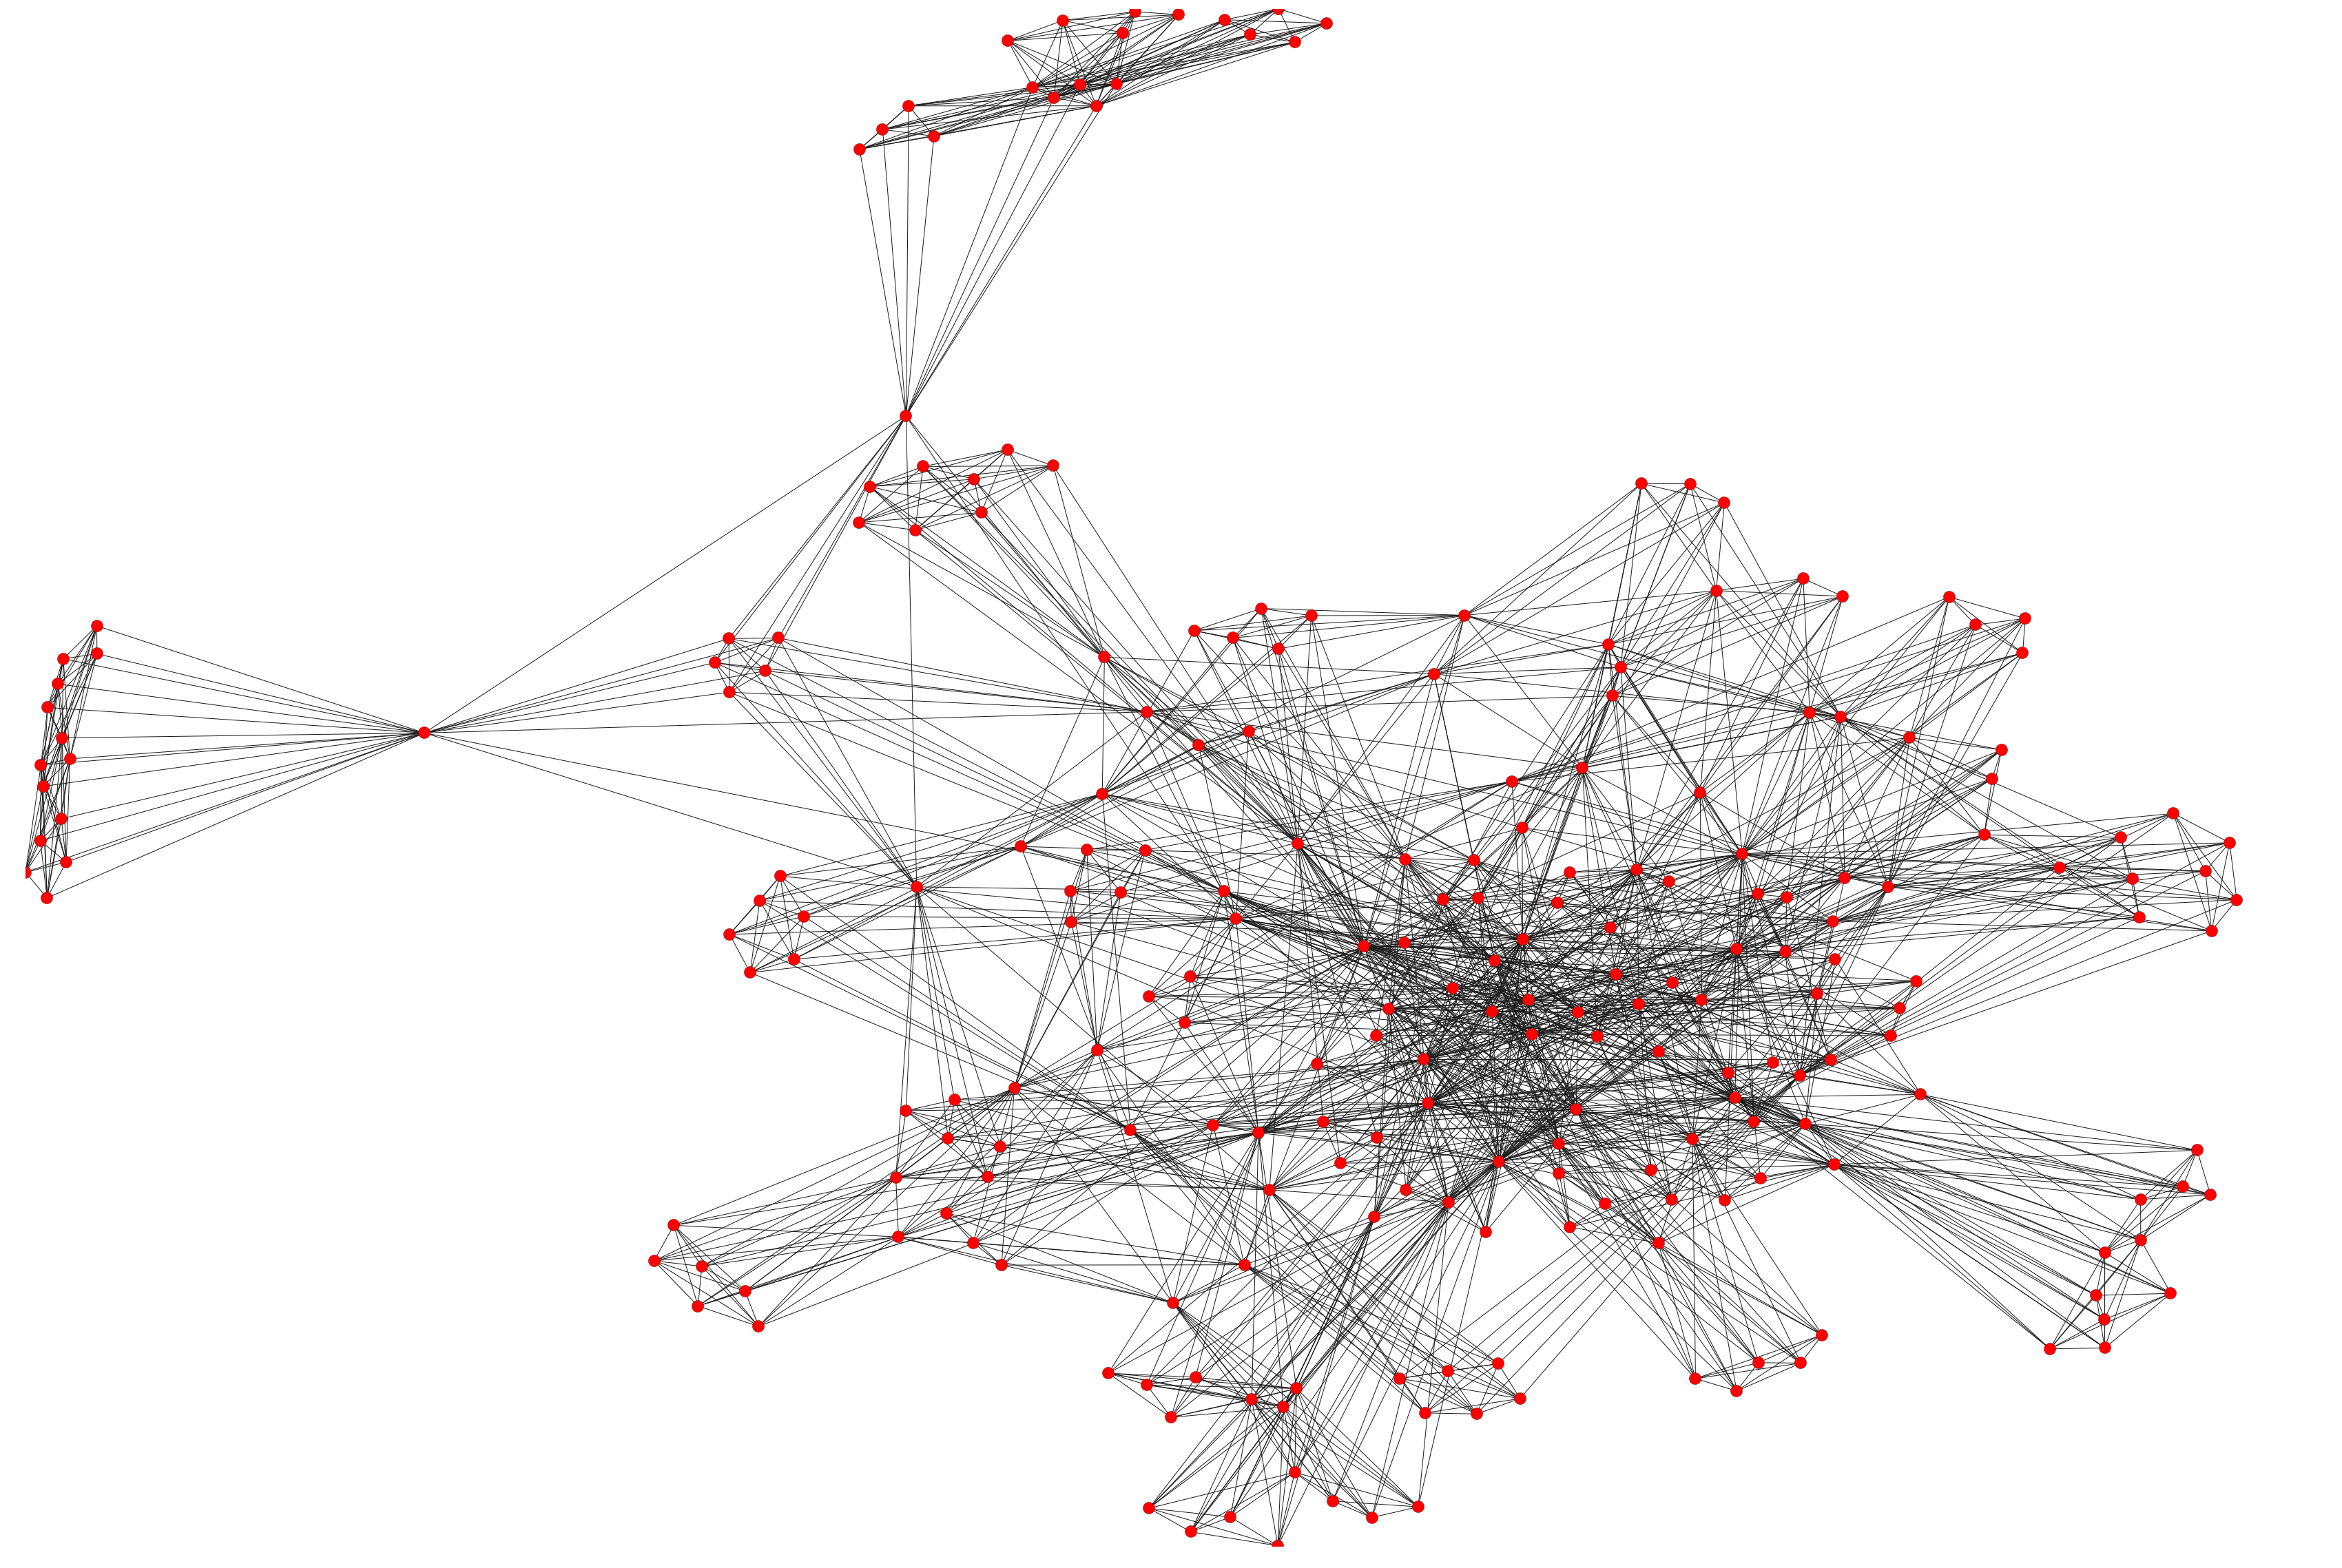

In [108]:
fig, ax = plt.subplots(figsize=(60,40))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
nx.draw(g, node_color='red', with_labels=False, font_size=4, node_size=300, ax=ax)

In [109]:
plt.savefig("g.png")

### Calculate centrality in the network

In [110]:
s_degree_centrality = pd.Series(nx.degree_centrality(g))
s_betweenness_centrality = pd.Series(nx.betweenness_centrality(g))
s_closeness_centrality = pd.Series(nx.closeness_centrality(g))
df = pd.concat((s_degree_centrality, s_betweenness_centrality, s_closeness_centrality), axis=1, keys=['degree_centrality','betweenness_centrality', 'closeness_centrality'])
df.head()

degree_centrality  betweenness_centrality  closeness_centrality
170340             0.066390                0.003665              0.372488
18991200           0.141079                0.059285              0.455577
19199530           0.053942                0.000591              0.397690
19451735           0.037344                0.000000              0.386218
19470447           0.037344                0.000000              0.384984

### Most important people in the network based on degree centrality

In [111]:
df.sort_values('degree_centrality', ascending=False).head()

degree_centrality  betweenness_centrality  closeness_centrality
21903966           0.257261                0.070357              0.470703
21883744           0.236515                0.084162              0.508439
30255016           0.224066                0.062745              0.479125
65409090           0.211618                0.075673              0.490835
30871780           0.211618                0.068657              0.463462

In [112]:
### get summoner info by id ###

most_deg_central_nodes = ['21903966', '21883744', '30255016', '65409090', '30871780']

api = RiotAPI(api_key)

print("Most important players according to degree_centrality:")
for importantnodeid in most_deg_central_nodes:
    iddata = api.get_name_by_summonerid(importantnodeid)
    print(iddata[importantnodeid]['name'])
    time.sleep(1)

Most important players according to degree_centrality:
https://na.api.pvp.net/api/lol/na/v1.4/summoner/21903966?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
Pekin Woof
https://na.api.pvp.net/api/lol/na/v1.4/summoner/21883744?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
Masterfiend LFT
https://na.api.pvp.net/api/lol/na/v1.4/summoner/30255016?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
TheeBrandini
https://na.api.pvp.net/api/lol/na/v1.4/summoner/65409090?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
GodPiglet
https://na.api.pvp.net/api/lol/na/v1.4/summoner/30871780?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
CloudNguyen


# === Time Series Data Prep ===

In [113]:
top5 = sums[:9]

print(top5)

['GodPiglet', 'Chapanya', 'caaaaaaaaaaaaake', 'Imagine Moon', 'Rikara', 'Turtle the Cat', 'Imagine baby', 'zero and ten', 'Short Dog']


In [114]:
if 'Rikara' in top5:         # Rikara was buggy, decided to remove him to avoid future bugs
    top5.remove('Rikara')
print(top5)

['GodPiglet', 'Chapanya', 'caaaaaaaaaaaaake', 'Imagine Moon', 'Turtle the Cat', 'Imagine baby', 'zero and ten', 'Short Dog']


In [115]:
if 'caaaaaaaaaaaaake' in top5:
    top5.remove('caaaaaaaaaaaaake')
print(top5)

['GodPiglet', 'Chapanya', 'Imagine Moon', 'Turtle the Cat', 'Imagine baby', 'zero and ten', 'Short Dog']


In [116]:
if 'Imagine Moon' in top5:
    top5.remove('Imagine Moon')
print(top5)

['GodPiglet', 'Chapanya', 'Turtle the Cat', 'Imagine baby', 'zero and ten', 'Short Dog']


In [117]:
if 'Imagine baby' in top5:
    top5.remove('Imagine baby')
print(top5)

['GodPiglet', 'Chapanya', 'Turtle the Cat', 'zero and ten', 'Short Dog']


In [118]:
top5dict = {}
top5ids = []

for name in top5:                                 # create dictionary of names + summonerIDs for each name
    top5dict[name] = {}
    lowername = name.lower()
    fixedname = lowername.replace(" ", "")
    data = api.get_summoner_by_name(fixedname)
    time.sleep(1)
    #print(data)
    top5dict[name]['id'] = data[fixedname]['id']
    sumid = data[fixedname]['id']
    top5ids.append(sumid)
    
print(top5dict)
print(top5ids)

https://na.api.pvp.net/api/lol/na/v1.4/summoner/by-name/godpiglet?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
https://na.api.pvp.net/api/lol/na/v1.4/summoner/by-name/chapanya?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
https://na.api.pvp.net/api/lol/na/v1.4/summoner/by-name/turtlethecat?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
https://na.api.pvp.net/api/lol/na/v1.4/summoner/by-name/zeroandten?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
https://na.api.pvp.net/api/lol/na/v1.4/summoner/by-name/shortdog?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
{'Short Dog': {'id': 44979352}, 'GodPiglet': {'id': 65409090}, 'zero and ten': {'id': 44989342}, 'Turtle the Cat': {'id': 18991200}, 'Chapanya': {'id': 20833616}}
[65409090, 20833616, 18991200, 44989342, 44979352]


In [119]:
matchids = []

for i, summoner in enumerate(top5):
    print(str(i+1) + " of " + str(len(top5ids)))
    matchhistory = api.get_matches_by_summonerid(top5dict[summoner]['id'])
    time.sleep(1)
    top5dict[summoner]['matchhistory'] = matchhistory
    matchlist = matchhistory['matches']
    for match in shortlist:
        matchid = match['matchId']
        #print(matchid)
        matchids.append(matchid)
        #print("\n")

1 of 5
https://na.api.pvp.net/api/lol/na/v2.2/matchlist/by-summoner/65409090?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
2 of 5
https://na.api.pvp.net/api/lol/na/v2.2/matchlist/by-summoner/20833616?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
3 of 5
https://na.api.pvp.net/api/lol/na/v2.2/matchlist/by-summoner/18991200?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
4 of 5
https://na.api.pvp.net/api/lol/na/v2.2/matchlist/by-summoner/44989342?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3
5 of 5
https://na.api.pvp.net/api/lol/na/v2.2/matchlist/by-summoner/44979352?api_key=aa68e6e0-d42b-40d7-b855-cc77ee03b3b3


In [120]:
print(top5dict)

{'Short Dog': {'id': 44979352, 'matchhistory': {'endIndex': 1068, 'matches': [{'champion': 43, 'season': 'PRESEASON2016', 'timestamp': 1451901774340, 'role': 'SOLO', 'platformId': 'NA1', 'region': 'NA', 'queue': 'RANKED_SOLO_5x5', 'lane': 'MID', 'matchId': 2058494663}, {'champion': 107, 'season': 'PRESEASON2016', 'timestamp': 1451357774337, 'role': 'NONE', 'platformId': 'NA1', 'region': 'NA', 'queue': 'RANKED_SOLO_5x5', 'lane': 'JUNGLE', 'matchId': 2052260866}, {'champion': 78, 'season': 'PRESEASON2016', 'timestamp': 1450144668494, 'role': 'NONE', 'platformId': 'NA1', 'region': 'NA', 'queue': 'RANKED_SOLO_5x5', 'lane': 'JUNGLE', 'matchId': 2038228858}, {'champion': 78, 'season': 'PRESEASON2016', 'timestamp': 1449740260588, 'role': 'NONE', 'platformId': 'NA1', 'region': 'NA', 'queue': 'RANKED_SOLO_5x5', 'lane': 'JUNGLE', 'matchId': 2033615412}, {'champion': 78, 'season': 'PRESEASON2016', 'timestamp': 1449736317653, 'role': 'NONE', 'platformId': 'NA1', 'region': 'NA', 'queue': 'RANKED_SO

In [121]:
# number of games in match history for each player

for summoner in top5dict:
    print(summoner + " has " + str((len(top5dict[summoner]['matchhistory']['matches']))) + " matches in their match history.")

Short Dog has 1068 matches in their match history.
GodPiglet has 1113 matches in their match history.
zero and ten has 628 matches in their match history.
Turtle the Cat has 631 matches in their match history.
Chapanya has 480 matches in their match history.


In [122]:
#convert epoch in dictionary entries to datetime

for summoner in top5dict:
    #print(len(top5dict[summoner]['matchhistory']['matches']))
    for match in top5dict[summoner]['matchhistory']['matches']:
        tstamp = str(match['timestamp'])
        newtstamp = tstamp[:-3]
        inttstamp = int(newtstamp)
        date = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(inttstamp))
        #date = datetime.datetime.fromtimestamp(inttstamp).strftime('%Y-%m-%d %H:%M:%S')
        match['date'] = date      # add converted date to the dictionary

In [123]:
api = RiotAPI(api_key)

In [124]:
### get detailed match data of each of the top 5 players ###

#matchdata = api.get_match_by_matchid('2037173430')
#print(len(matchhistory['matches']))

#for participant in matchdata['participantIdentities']:
#    print(participant['player']['summonerId'])              # summoner ids per match

api = RiotAPI(api_key)

GodPiglet_matchlist = top5dict['GodPiglet']['matchhistory']['matches'][:480]
Chapanya_matchlist = top5dict['Chapanya']['matchhistory']['matches'][:480]
ShortDog_matchlist = top5dict['Short Dog']['matchhistory']['matches'][:480]
zeroandten_matchlist = top5dict['zero and ten']['matchhistory']['matches'][:480]
TurtletheCat_matchlist = top5dict['Turtle the Cat']['matchhistory']['matches'][:480]

In [125]:
### DON'T RUN TO SAVE TIME ###
"""# get detailed match data for GodPiglet
for i, matches in enumerate(GodPiglet_matchlist):
    print(str(i+1) + " of " + str(len(GodPiglet_matchlist)))
    matchid = matches['matchId']
    #print(matchid)
    matchdata = api.get_match_by_matchid(matchid)
    time.sleep(1)
    matches['matchdata'] = matchdata
"""

'# get detailed match data for GodPiglet\nfor i, matches in enumerate(GodPiglet_matchlist):\n    print(str(i+1) + " of " + str(len(GodPiglet_matchlist)))\n    matchid = matches[\'matchId\']\n    #print(matchid)\n    matchdata = api.get_match_by_matchid(matchid)\n    time.sleep(1)\n    matches[\'matchdata\'] = matchdata\n'

In [126]:
### DON'T RUN TO SAVE TIME ###
"""# get detailed match data for Turtle the Cat
for i, matches in enumerate(TurtletheCat_matchlist):
    print(str(i+1) + " of " + str(len(TurtletheCat_matchlist)))
    matchid = matches['matchId']
    #print(matchid)
    matchdata = api.get_match_by_matchid(matchid)
    time.sleep(1)
    matches['matchdata'] = matchdata
"""

'# get detailed match data for Turtle the Cat\nfor i, matches in enumerate(TurtletheCat_matchlist):\n    print(str(i+1) + " of " + str(len(TurtletheCat_matchlist)))\n    matchid = matches[\'matchId\']\n    #print(matchid)\n    matchdata = api.get_match_by_matchid(matchid)\n    time.sleep(1)\n    matches[\'matchdata\'] = matchdata\n'

In [127]:
### DON'T RUN TO SAVE TIME ###
"""# get detailed match data for Chapanya
for i, matches in enumerate(Chapanya_matchlist):
    print(str(i+1) + " of " + str(len(Chapanya_matchlist)))
    matchid = matches['matchId']
    #print(matchid)
    matchdata = api.get_match_by_matchid(matchid)
    time.sleep(1)
    matches['matchdata'] = matchdata
"""

'# get detailed match data for Chapanya\nfor i, matches in enumerate(Chapanya_matchlist):\n    print(str(i+1) + " of " + str(len(Chapanya_matchlist)))\n    matchid = matches[\'matchId\']\n    #print(matchid)\n    matchdata = api.get_match_by_matchid(matchid)\n    time.sleep(1)\n    matches[\'matchdata\'] = matchdata\n'

In [128]:
### DON'T RUN TO SAVE TIME ###
"""# get detailed match data for zero and ten
for i, matches in enumerate(zeroandten_matchlist):
    print(str(i+1) + " of " + str(len(zeroandten_matchlist)))
    matchid = matches['matchId']
    #print(matchid)
    matchdata = api.get_match_by_matchid(matchid)
    time.sleep(1)
    matches['matchdata'] = matchdata
"""

'# get detailed match data for zero and ten\nfor i, matches in enumerate(zeroandten_matchlist):\n    print(str(i+1) + " of " + str(len(zeroandten_matchlist)))\n    matchid = matches[\'matchId\']\n    #print(matchid)\n    matchdata = api.get_match_by_matchid(matchid)\n    time.sleep(1)\n    matches[\'matchdata\'] = matchdata\n'

In [129]:
### DON'T RUN TO SAVE TIME ###
"""# get detailed match data for Short Dog
for i, matches in enumerate(ShortDog_matchlist):
    print(str(i+1) + " of " + str(len(ShortDog_matchlist)))
    matchid = matches['matchId']
    #print(matchid)
    matchdata = api.get_match_by_matchid(matchid)
    time.sleep(1)
    matches['matchdata'] = matchdata
"""

'# get detailed match data for Short Dog\nfor i, matches in enumerate(ShortDog_matchlist):\n    print(str(i+1) + " of " + str(len(ShortDog_matchlist)))\n    matchid = matches[\'matchId\']\n    #print(matchid)\n    matchdata = api.get_match_by_matchid(matchid)\n    time.sleep(1)\n    matches[\'matchdata\'] = matchdata\n'

In [130]:
"""zeroandten_matchlist_json = json.dumps(zeroandten_matchlist)
f = open('zeroandten_matchlist.txt', 'w')
f.write(zeroandten_matchlist_json)
f.close()"""

"zeroandten_matchlist_json = json.dumps(zeroandten_matchlist)\nf = open('zeroandten_matchlist.txt', 'w')\nf.write(zeroandten_matchlist_json)\nf.close()"

In [131]:
"""
Chapanya_matchlist_json = json.dumps(Chapanya_matchlist)
f = open('Chapanya_matchlist.txt', 'w')
f.write(Chapanya_matchlist_json)
f.close()
"""

"\nChapanya_matchlist_json = json.dumps(Chapanya_matchlist)\nf = open('Chapanya_matchlist.txt', 'w')\nf.write(Chapanya_matchlist_json)\nf.close()\n"

In [132]:
"""
TurtletheCat_matchlist_json = json.dumps(TurtletheCat_matchlist)
f = open('TurtletheCat_matchlist.txt', 'w')
f.write(TurtletheCat_matchlist_json)
f.close()
"""

"\nTurtletheCat_matchlist_json = json.dumps(TurtletheCat_matchlist)\nf = open('TurtletheCat_matchlist.txt', 'w')\nf.write(TurtletheCat_matchlist_json)\nf.close()\n"

In [133]:
"""
GodPiglet_matchlist_json = json.dumps(GodPiglet_matchlist)
f = open('GodPiglet_matchlist.txt', 'w')
f.write(GodPiglet_matchlist_json)
f.close()
"""

"\nGodPiglet_matchlist_json = json.dumps(GodPiglet_matchlist)\nf = open('GodPiglet_matchlist.txt', 'w')\nf.write(GodPiglet_matchlist_json)\nf.close()\n"

In [134]:
"""
ShortDog_matchlist_json = json.dumps(ShortDog_matchlist)
f = open('ShortDog_matchlist.txt', 'w')
f.write(ShortDog_matchlist_json)
f.close()
"""

"\nShortDog_matchlist_json = json.dumps(ShortDog_matchlist)\nf = open('ShortDog_matchlist.txt', 'w')\nf.write(ShortDog_matchlist_json)\nf.close()\n"

In [135]:
f = open('zeroandten_matchlist.txt', 'r')
zeroandten_matchlist = json.load(f)
f.close()

f = open('Chapanya_matchlist.txt', 'r')
Chapanya_matchlist = json.load(f)
f.close()

f = open('TurtletheCat_matchlist.txt', 'r')
TurtletheCat_matchlist = json.load(f)
f.close()

f = open('GodPiglet_matchlist.txt', 'r')
GodPiglet_matchlist = json.load(f)
f.close()

f = open('ShortDog_matchlist.txt', 'r')
ShortDog_matchlist = json.load(f)
f.close()

### Get short matchlists and then retrieve detailed data (game stats) for each player

In [136]:
# get shortened matchlist for each player (only 40 matches)
# this is the place I was having trouble getting any data to work over 40 matches

GodPiglet_shortmatchlist = GodPiglet_matchlist[:100]
TurtletheCat_shortmatchlist = TurtletheCat_matchlist[:100]
Chapanya_shortmatchlist = Chapanya_matchlist[:100]
ShortDog_shortmatchlist = ShortDog_matchlist[:100]
zeroandten_shortmatchlist = zeroandten_matchlist[:100]

In [137]:
for item in zeroandten_matchlist[100]['matchdata']['participantIdentities']:
    print(item)

{'participantId': 1, 'player': {'summonerName': 'Jimmy Talon', 'summonerId': 25738593, 'profileIcon': 968, 'matchHistoryUri': '/v1/stats/player_history/NA/40404670'}}
{'participantId': 2, 'player': {'summonerName': 'Urii', 'summonerId': 28910586, 'profileIcon': 9, 'matchHistoryUri': '/v1/stats/player_history/NA1/43101683'}}
{'participantId': 3, 'player': {'summonerName': 'ice', 'summonerId': 401169, 'profileIcon': 547, 'matchHistoryUri': '/v1/stats/player_history/NA/428001'}}
{'participantId': 4, 'player': {'summonerName': 'Rohammers', 'summonerId': 20112175, 'profileIcon': 505, 'matchHistoryUri': '/v1/stats/player_history/NA/32944345'}}
{'participantId': 5, 'player': {'summonerName': 'Hakuho', 'summonerId': 21193669, 'profileIcon': 971, 'matchHistoryUri': '/v1/stats/player_history/NA/34486740'}}
{'participantId': 6, 'player': {'summonerName': 'Short Dog', 'summonerId': 44979352, 'profileIcon': 939, 'matchHistoryUri': '/v1/stats/player_history/NA1/208283500'}}
{'participantId': 7, 'pla

In [138]:
# get GodPiglet's personal game stats and add stats entry to GodPiglet's dictionary

#print(GodPiglet_shortmatchlist)

for matchdicti in GodPiglet_matchlist:
    #print(matchdicti['matchdata']['participantIdentities'])
    for participant in matchdicti['matchdata']['participantIdentities']:
        #print(participant['player']['summonerName'])
        if "GodPiglet" in participant['player']['summonerName']:
            matchdicti['matchdata']['participId'] = participant['participantId']
            
    for particip in matchdicti['matchdata']['participants']:
        if particip['participantId'] == matchdicti['matchdata']['participId']:
            matchdicti['personal_stats'] = particip['stats']

In [139]:
# get TurtletheCat's personal game stats and add stats entry to TurtletheCat's dictionary

for matchdicti in TurtletheCat_matchlist:
    #print(matchdicti['matchdata']['participantIdentities'])
    for participant in matchdicti['matchdata']['participantIdentities']:
        #print(participant['player']['summonerName'])
        if "Turtle the Cat" in participant['player']['summonerName']:
            matchdicti['matchdata']['participId'] = participant['participantId']
            
    for particip in matchdicti['matchdata']['participants']:
        if particip['participantId'] == matchdicti['matchdata']['participId']:
            matchdicti['personal_stats'] = particip['stats']

In [140]:
# get Chapanya's personal game stats and add stats entry to Chapanya's dictionary

for matchdicti in Chapanya_matchlist:
    for participant in matchdicti['matchdata']['participantIdentities']:
        #print(participant['player']['summonerName'])
        if "Chapanya" in participant['player']['summonerName']:
            matchdicti['matchdata']['participId'] = participant['participantId']
            #print(matchdicti['matchdata']['participId'])
            
    for particip in matchdicti['matchdata']['participants']:
        if particip['participantId'] == matchdicti['matchdata']['participId']:
            matchdicti['personal_stats'] = particip['stats']

In [141]:
# get zero and ten's personal game stats and add stats entry to zero and ten's dictionary

for matchdicti in zeroandten_matchlist:
    for participant in matchdicti['matchdata']['participantIdentities']:
        #print(participant['player']['summonerName'])
        if "zero and ten" in participant['player']['summonerName']:
            matchdicti['matchdata']['participId'] = participant['participantId']
            #print(matchdicti['matchdata']['participId'])
        elif "scorro" in participant['player']['summonerName']:
            matchdicti['matchdata']['participId'] = participant['participantId']
        elif "IlIIllllIIllIIll" in participant['player']['summonerName']:
            matchdicti['matchdata']['participId'] = participant['participantId']
            
    for particip in matchdicti['matchdata']['participants']:
        if particip['participantId'] == matchdicti['matchdata']['participId']:
            matchdicti['personal_stats'] = particip['stats']

In [142]:
# get Short Dog's personal game stats and add stats entry to Imagine baby's dictionary

for matchdicti in ShortDog_matchlist:
    for participant in matchdicti['matchdata']['participantIdentities']:
        #print(participant['player']['summonerName'])
        if "Short Dog" in participant['player']['summonerName']:
            matchdicti['matchdata']['participId'] = participant['participantId']
            #print(matchdicti['matchdata']['participId'])
            
    for particip in matchdicti['matchdata']['participants']:
        if particip['participantId'] == matchdicti['matchdata']['participId']:
            matchdicti['personal_stats'] = particip['stats']

In [143]:
#for item in (Imaginebaby_matchlist[449]['matchdata']['participantIdentities']):
#    print(item['player']['summonerName'])

# === Time Series: Average Damage Dealt over Time ===

In [144]:
# testing out data structure for printing damage dealt to champions
print(zeroandten_matchlist[0]['personal_stats']['totalDamageDealtToChampions'])
#print(zeroandten_shortmatchlist[0]['personal_stats'])

16638


In [145]:
# testing out data structure for printing out date for each match
print(zeroandten_shortmatchlist[0]['date'])

2015-12-20 23:56:40


### Generate average damage dealt to champions per day per player

In [146]:
# write all this to csv

with open('damagedealt.csv', 'w') as a:
    b = csv.writer(a, lineterminator = '\n')

    writer = ['Date', 'zero and ten', 'Chapanya', 'Short Dog', 'Turtle the Cat', 'GodPiglet']
    #writer = ['Date', 'Name', 'AvgDamage']
    b.writerow(writer)   #titles at the top of csv

    for match in zeroandten_matchlist:
        date = match['date'][:10]
        dmg = match['personal_stats']['totalDamageDealtToChampions']
        writer = [date, dmg]
        b.writerow(writer)
    
    for match in Chapanya_matchlist:
        date = match['date'][:10]
        dmg = match['personal_stats']['totalDamageDealtToChampions']
        writer = [date, '', dmg]
        b.writerow(writer)
        
    for match in ShortDog_matchlist:
        date = match['date'][:10]
        dmg = match['personal_stats']['totalDamageDealtToChampions']
        writer = [date, '', '', dmg]
        b.writerow(writer)
        
    for match in TurtletheCat_matchlist:
        date = match['date'][:10]
        dmg = match['personal_stats']['totalDamageDealtToChampions']
        writer = [date, '', '', '', dmg]
        b.writerow(writer)
    
    for match in GodPiglet_matchlist:
        date = match['date'][:10]
        dmg = match['personal_stats']['totalDamageDealtToChampions']
        writer = [date, '', '', '', '', dmg]
        b.writerow(writer)
    
    a.close()

In [147]:
# Read the table from a CSV file
df_dmg = pd.read_csv('final_damagedealt.csv', parse_dates=True, index_col=0)

In [148]:
df_dmg.head(10)

Average of zero and ten  Average of Chapanya  Average of Short Dog  \
Date                                                                            
5/4/2014                       NaN           2817.00000                   NaN   
5/7/2014                       NaN          23280.80000                   NaN   
5/13/2014                      NaN          14700.33333                   NaN   
5/20/2014                      NaN          14404.00000                   NaN   
5/29/2014                      NaN           9364.00000                   NaN   
6/5/2014                       NaN          21716.33333                   NaN   
6/13/2014                      NaN           5236.00000                   NaN   
6/21/2014                      NaN          26192.00000                   NaN   
6/29/2014                      NaN           5159.00000                   NaN   
7/6/2014                       NaN          20109.00000                   NaN   

           Average of GodPiglet  Average of Turtle the Cat  
Date                                                        
5/4/2014                    NaN                        NaN  
5/7/2014                    NaN                        NaN  
5/13/2014                   NaN                        NaN  
5/20/2014                   NaN                        NaN  
5/29/2014                   NaN                        NaN  
6/5/2014                    NaN                        NaN  
6/13/2014                   NaN                        NaN  
6/21/2014                   NaN                        NaN  
6/29/2014                   NaN                        NaN  
7/6/2014                    NaN                        NaN

In [149]:
df_dmg.tail(10)

Average of zero and ten  Average of Chapanya  \
Date                                                        
12/15/2015                       NaN                  NaN   
12/16/2015                       NaN                  NaN   
12/17/2015                       NaN                  NaN   
12/18/2015                       NaN                  NaN   
12/19/2015                       NaN                  NaN   
12/20/2015               21476.33333                  NaN   
12/21/2015                       NaN                  NaN   
12/28/2015                       NaN                  NaN   
1/4/2016                         NaN                  NaN   
Grand Total              23615.00833          21017.72292   

             Average of Short Dog  Average of GodPiglet  \
Date                                                      
12/15/2015                    NaN           19208.36364   
12/16/2015                    NaN           17727.00000   
12/17/2015                    NaN           24311.14286   
12/18/2015                    NaN           19567.20000   
12/19/2015                    NaN           20919.36364   
12/20/2015                    NaN           17318.70000   
12/21/2015                    NaN           23856.00000   
12/28/2015            11412.00000                   NaN   
1/4/2016              21121.00000                   NaN   
Grand Total           16527.46042           19853.14583   

             Average of Turtle the Cat  
Date                                    
12/15/2015                 24029.50000  
12/16/2015                 20584.20000  
12/17/2015                 22707.00000  
12/18/2015                 19542.25000  
12/19/2015                 17765.33333  
12/20/2015                 19253.00000  
12/21/2015                         NaN  
12/28/2015                         NaN  
1/4/2016                           NaN  
Grand Total                22722.86250

In [150]:
#Delete grand total row
df_dmg = df_dmg.ix[:-1]

In [151]:
shortdf = df_dmg['5/25/2015':]

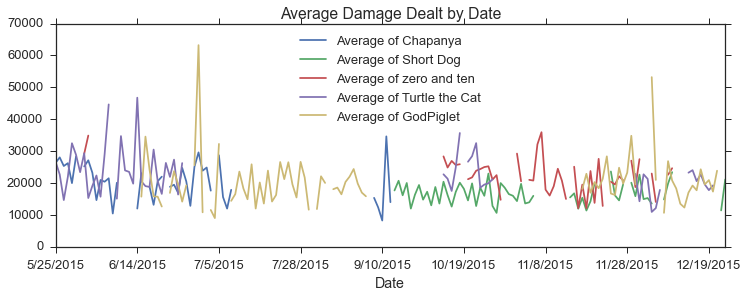

In [152]:
fig, ax = plt.subplots(figsize=(12,4))
shortdf[['Average of Chapanya', 'Average of Short Dog', 'Average of zero and ten', 'Average of Turtle the Cat', 'Average of GodPiglet']].plot(ax=ax)
plt.title('Average Damage Dealt by Date')

### If I were to do it differently next time:
#### - I would make sure the dates played were consistent so I could accurately compare each of the players' average damage per day
#### - I would exclude games played as support

# === Regression Analysis: Gold Spent vs. Damage Dealt ===

In [153]:
# testing out data structure for next cell
print(TurtletheCat_matchlist[0]['personal_stats']['totalDamageDealtToChampions'])
print(TurtletheCat_matchlist[0]['personal_stats']['goldSpent'])
#print(TurtletheCat_newshortmatchlist[0]['personal_stats'])

14140
9325


In [154]:
print(TurtletheCat_matchlist[0]['personal_stats']['totalDamageDealtToChampions'])
print(TurtletheCat_matchlist[0]['personal_stats']['largestCriticalStrike'])

14140
456


In [155]:
#for item in (TurtletheCat_matchlist[0]['personal_stats']):
#    print(item)

In [156]:
# make a csv with Turtle the Cat's total damage dealt to champions and largest crit per game

with open('TurtletheCatReg2.csv', 'w') as a:
    b = csv.writer(a, lineterminator = '\n')

    writer = ['Damage', 'CritStrike']
    b.writerow(writer)   #titles at the top of csv

    for match in TurtletheCat_matchlist:
        dmg = match['personal_stats']['totalDamageDealtToChampions']
        crit = match['personal_stats']['largestCriticalStrike']
        #writer = [date, 'caaaaaaaaaaaaake', dmg]
        writer = [dmg, crit]
        b.writerow(writer)
    
    a.close()

In [157]:
# Read the table from the CSV file
df_turtlecat2 = pd.read_csv('TurtletheCatReg2.csv')

In [158]:
df_turtlecat2.head()

Damage  CritStrike
0   14140         456
1   30547         896
2   13072         428
3   21523         513
4   24697         561

In [169]:
# remove instances of Damage when Crit is 0
df_turtlecat2 = df_turtlecat2[df_turtlecat2.CritStrike != 0]

(0, 2000.0)

C:\Users\Nicole\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


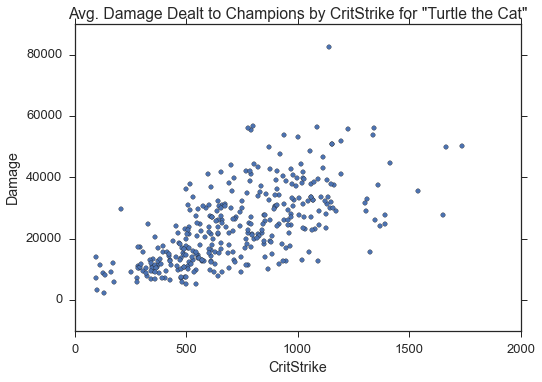

In [160]:
df_turtlecat2.plot(x='CritStrike', y='Damage', kind='scatter');
plt.title('Avg. Damage Dealt to Champions by CritStrike for "Turtle the Cat"')
plt.xlim(xmin=0)

C:\Users\Nicole\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


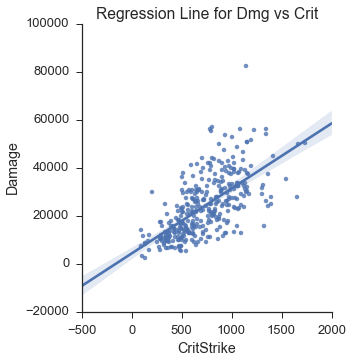

In [161]:
# Crit is X, Damage is Y
model2h = smf.ols('Damage ~ CritStrike', data=df_turtlecat2).fit()

# Plot the regression line together with the data
xs = np.linspace(3, 15, 2)
ys_predicted = model2h.predict({'CritStrike': xs})
sns.lmplot(x='CritStrike', y='Damage', data=df_turtlecat2);
sns.set_style('darkgrid')
plt.title('Regression Line for Dmg vs Crit')

In [162]:
# make a csv with Turtle the Cat's gold spent and damage dealt to champions per game

with open('TurtletheCatGoldSpent.csv', 'w') as a:
    b = csv.writer(a, lineterminator = '\n')

    writer = ['Damage', 'GoldSpent']
    b.writerow(writer)   #titles at the top of csv

    for match in TurtletheCat_matchlist:
        dmg = match['personal_stats']['totalDamageDealtToChampions']
        gold = match['personal_stats']['goldSpent']
        #writer = [date, 'caaaaaaaaaaaaake', dmg]
        writer = [dmg, gold]
        b.writerow(writer)
    
    a.close()

In [163]:
# Read the table from the CSV file
df_turtlecat = pd.read_csv('TurtletheCatGoldSpent.csv')

In [164]:
df_turtlecat.head()

Damage  GoldSpent
0   14140       9325
1   30547      12175
2   13072       9425
3   21523      12025
4   24697      12950

C:\Users\Nicole\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


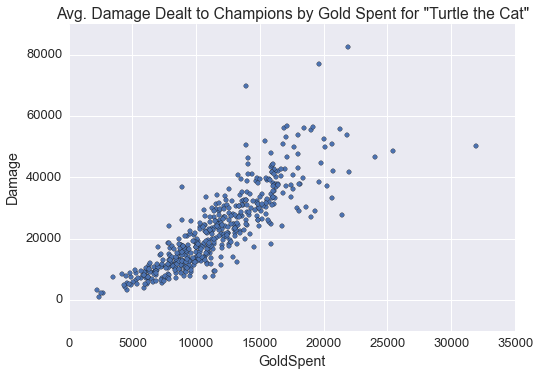

In [165]:
df_turtlecat.plot(x='GoldSpent', y='Damage', kind='scatter');
plt.title('Avg. Damage Dealt to Champions by Gold Spent for "Turtle the Cat"')

C:\Users\Nicole\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


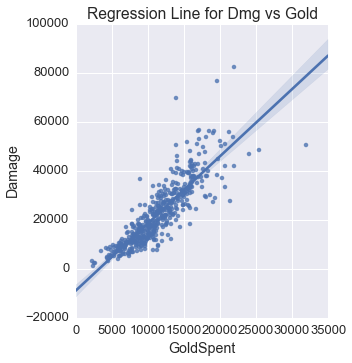

In [166]:
# GoldSpent is X, Damage is Y
model2h = smf.ols('Damage ~ GoldSpent', data=df_turtlecat).fit()

# Plot the regression line together with the data
xs = np.linspace(3, 15, 2)
ys_predicted = model2h.predict({'GoldSpent': xs})
sns.lmplot(x='GoldSpent', y='Damage', data=df_turtlecat);
sns.set_style('darkgrid')
plt.title('Regression Line for Dmg vs Gold')

# === Outlier Detection & Removal ===

### Outlier Detection

In [167]:
# Cook's Distance
influence = model2h.get_influence()
cooks_distance = influence.cooks_distance[0]
no_of_observations = len(df_turtlecat)

# Use an empirical threshold value
cooks_threshold = 4 / no_of_observations

# Show outliers
df_turtlecat[['Damage', 'GoldSpent']][cooks_distance > cooks_threshold]

# Remove outliers using Cook's Distance
outlier_criterion = (cooks_distance > cooks_threshold)
outlier_indexes = np.nonzero(outlier_criterion)[0]
df_turtlecat_no_outliers = df_turtlecat[~outlier_criterion]

# New model without outliers
model2k = smf.ols('Damage ~ GoldSpent', data = df_turtlecat_no_outliers).fit()

# Summarize new model
model2k.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Damage   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1883.
Date:                Fri, 08 Jan 2016   Prob (F-statistic):          1.47e-162
Time:                        14:04:30   Log-Likelihood:                -4457.2
No. Observations:                 450   AIC:                             8918.
Df Residuals:                     448   BIC:                             8927.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -9929.9862    752.610    -13.194      0.000     -1.14e+04 -8450.903
GoldSpent      2.8082      0.065     43.397      0.000         2.681     2.935
==============================================================================
Omnibus:                        1.448   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.485   Jarque-Bera (JB):                1.284
Skew:                           0.031   Prob(JB):                        0.526
Kurtosis:                       3.254   Cond. No.                     3.82e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### New plot with old + new regression line (with and without outliers)

C:\Users\Nicole\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


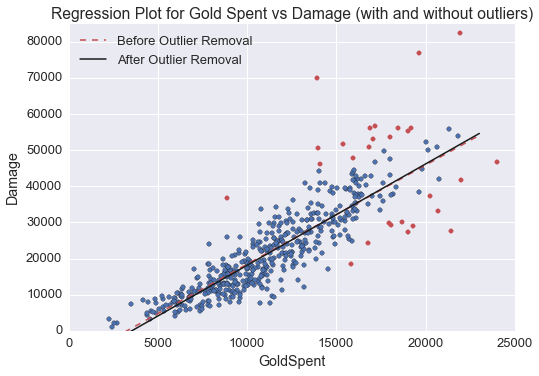

In [168]:
# Plot a new scatterplot showing both old + new regression line

newscatter = np.linspace(200, 23000, 2)

predicted1 = model2h.predict({'GoldSpent': newscatter})
predicted2 = model2k.predict({'GoldSpent': newscatter})

plt.scatter(df_turtlecat_no_outliers.GoldSpent, df_turtlecat_no_outliers.Damage, s = 20, marker = 'o');
plt.scatter(df_turtlecat.ix[outlier_indexes, 'GoldSpent'], df_turtlecat.ix[outlier_indexes, 'Damage'], s = 20, color = 'r', marker = 'o');

plt.plot(newscatter, predicted1, 'r--', lw = 1.5, label = 'Before Outlier Removal');
plt.plot(newscatter, predicted2, 'k', lw = 1.5, label = 'After Outlier Removal');
plt.legend(loc = 'upper left');
plt.xlim(xmin=0, xmax=25000)
plt.ylim(ymin=0, ymax=85000)
plt.xlabel('GoldSpent');
plt.ylabel('Damage');
plt.title('Regression Plot for Gold Spent vs Damage (with and without outliers)')